# Deep Learning for Audio Part 3 - Training to Recognize Human Speech with Larger DNN
### Building a Deep Google Speech Commands Classifier

This is the third notebook in the series which shows how to tackle audio problems with Deep Learning (DL) on Microsoft's Data Science Virtual Machine (DS VM). The purpose of this notebook is to illutrae how a DL model can be trained to classify 1-second audio clips of voice commands given by a human. You will learn how to pre-process audio data from a variety of sources, how to design and train a DL model with Graphical Processing Unit (GPU) hardware acceleration and you'll be able to score the trained model to evaluate its performance on a series of commands which were no included as part of training; you can also record your own audio and retrain the model on this data as well as see how well the trained model responds to your voice commands.


In [1]:
#change notebook settings for wider screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Dataset

We use the [Google Speech Commands](https://research.googleblog.com/2017/08/launching-speech-commands-dataset.html) dataset, which is [freely-available](http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz) under Creative Commons license.

## Prerequisites

Make sure you're running TensorFlow 1.4.0 or later (RC0 version is fine) and Keras 2.0.8 or later with GPU acceleration enabled; the code will still work without GPU, but we estimate the training times to take much longer. On DS VM with single GPU, we estimate the runtime of the entire notebook, including preprocessing, to be less than 20 minutes.

Once you download the dataset to DS VM, you only need to uncompress it and change the "config" class's variable "data_dir" below to point to its uncompressed contents. For example, if you downloaded the dataset to Downloads folder and uncompressed it there, you should set "data_dir" to "C:/Users/_your\_username_/Downloads/speech_commands/" on Windows and "/home/_your\_username_/Downloads/speech_commands/" or just "~/Downloads/speech_commands/" on Linux DS VM.

## TensorFlow and CNTK back ends

This tutorial works with both TensorFlow and CNTK back ends. If you want to run a CNTK back end, make sure you're running CNTK version 2.3 or higher (we haven't tested with earlier versions of CNTK, but they should also work). You can try enabling the CNTK back end on DS VM by locally setting KERAS_BACKEND environment variable to "cntk":

```
KERAS_BACKEND=cntk jupyter notebook
```

The default back end on DS VM is TensorFlow, but if you switch back end to CNTK the entire notebook will run with no changes in overall functionality. You can [permamently enable](https://keras.io/backend/) the CNTK back end by either modifying the Keras configuration file or by making KERAS_BACKEND and global environment variable.

## Acknowledgements

The following code is based on the [winning solution](https://arxiv.org/abs/1710.00343) to the [Task 4](http://www.cs.tut.fi/sgn/arg/dcase2017/documents/dcase-2017-challenge-paper.pdf) (large-scale weakly supervised sound event detection for smart cars) of the [Detection and Classification of Acoustic Scenes and Events (DCASE) 2017](http://www.cs.tut.fi/sgn/arg/dcase2017/challenge/task-large-scale-sound-event-detection) challenge. We thank Yong Xu, Qiuqiang Kong, Wenwu Wang and Mark D. Plumbley for making the [code](https://github.com/yongxuUSTC/dcase2017_task4_cvssp) to their solution publiclcy available online.

### Imports

Make sure you have the required versions of TensorFlow and Keras and that Keras is using TensorFlow as the required backend.

In [2]:
import tensorflow as tf
import keras
print ("You're running TensorFlow %s and Keras %s" % (tf.__version__, keras.__version__))

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


You're running TensorFlow 1.6.0 and Keras 2.1.4


Using TensorFlow backend.


Import the rest of the dependencies...

In [3]:
# matplotlib for displaying the output
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import pandas as pd
import seaborn as sn

import librosa
import librosa.display
import scipy
from scipy import signal
from scipy.fftpack import dct as scipy_fftpack_dct

import numpy as np
import hashlib
import re

import glob
import os
import shutil

'''
The pickle module implements an algorithm for turning an arbitrary Python object into a series of bytes. 
This process is also called serializing” the object. The byte stream representing the object can then be 
transmitted or stored, and later reconstructed to create a new object with the same characteristics.

The cPickle module implements the same algorithm, in C instead of Python. It is many times faster than the Python 
implementation, but does not allow the user to subclass from Pickle.

Python 3 uses _pickle to represent Python 2's cPickle class.
'''
import _pickle as cPickle
import time

import h5py
import sklearn
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, auc, confusion_matrix

import random

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute,Lambda, RepeatVector
from keras.layers.convolutional import ZeroPadding2D, AveragePooling2D, Conv2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers import Merge, Input, merge
# TODO: add LearningRateScheduler ??
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM, SimpleRNN, GRU, TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Multiply

# for preprocessing
import threading

Define the static configuration parameters used by the rest of the code.

In [4]:
class config:

    # move raw data around
    data_dir = "/mnt/speech_commands/"
    outdir = data_dir + "/compressed_hdf5"
    out_model_dir = data_dir + "/../models"
    
    #toggle whether we need to re-run data preprocessing
    redo_preprocessing = True
    
    # audio bitrate in Hz
    sample_rate = 16000.
    
    # maximum number of epochs
    num_epochs = 1e3

    # core voice commands which we want to classify
    words_core = list(set(["Yes", "No", "Up", "Down", "Left", "Right",
    "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four",
    "Five", "Six", "Seven", "Eight", "Nine"]))
    # voice commands and noises which form the negative set
    words_negative = list(set(["Bed", "Bird", "Cat", "Dog", "Happy", "House",
    "Marvin", "Sheila", "Tree", "Wow", "_background_noise_"]))

    lbs = words_core + ["_negative_"]

    num_classes = len(lbs)
    word_to_idx = {word: index for index, word in enumerate(lbs)}

    # validation and test set splits in percent
    frac_val = 10
    frac_test = 10        
    
    # size of audio window and overlap in Hz
    n_window = 1024
    n_overlap = 360
    # length of FFT segments
    max_len = 24    

    # fmin and fmax for librosa filters in Hz
    fmax = 8000.
    fmin = 0.
    
    # number of mel bands
    n_mels = 64
    
    # parameters which should probably be tuned with Batch AI:
    
    # pre emphasis (\alpha) coefficient in x(t) - alpha*x(t-1) equation
    # usually 0.95 or 0.97
    pre_emphasis = 0.
    
    # cepstal coefficient which to include
    # useful values are 1, 2, 3
    cepstal_coeff_low = 1
    # useful values are 12 - 16
    cepstal_coeff_high = 12
    n_cepstral_coeffs = cepstal_coeff_high - cepstal_coeff_low + 1

    # disable emphasis of raw audio waveform
    # pre_emphasis
    emphasis = True
    if not emphasis:
        pre_emphasis = 0.
        
    # enable liftering
    use_liftering = False
      
    # specifies whether to train on derived MFCC features are opposed to raw log-mel spectrogram
    use_MFCC = False
        
    # cep_lifter coefficient for sinusoidal lifter
    cep_lifter = 22

cfg = config()

## Preprocessing

We already showed how to featurize audio and spech data in Notebooks 1 and 2 - this notebook focuses on the mechanics of using the extracted features for training a machine learning model.

### Feature Extraction

We can now pre-process the raw audio data with the approach which we described in the previous notebook - we don't train on MFCCs but rather on the extracted log of the mel spectrogram (this approach is more generic and works for audio event detection, which is our ultimate goal - we are not focusing on speech recognition). 

We use a Google-supplied function (with minor alterations) to split the raw .wav files into train, validation and test sets, which are initially represented as folders on the attached filesystem (we could also do this on other filesystems like [Windows Azure Blob Storage (WASB)/HDFS](https://docs.microsoft.com/en-us/azure/hdinsight/hdinsight-hadoop-use-blob-storage) and [Azure Data Lake Store (ADLS)](https://docs.microsoft.com/en-us/azure/data-lake-store/data-lake-store-overview).

We use the following stages to pre-process the data into three HDF5 datasets and a scaling dataset (to normalize the data before training):
1. Split the raw files into different sets based on the supplied function from Google which uses a hash function on the filename to determine set membership.
2. Featurize the audio in each file into spectrogram array and serialize to binary filesystem representation.
3. Form HDF5 sets from featurized spectrograms.
4. Compute and save scaling factors (mean and standard deviation) on the training set and serialize the results back to the filesystem.


In [5]:
# Function from Google which splits the data into train and test sets

MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
  """Determines which data partition the file should belong to.

  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.

  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.

  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

  Returns:
    String, one of 'training', 'validation', or 'test'.
  """
  base_name = os.path.basename(filename)
  # We want to ignore anything after '_nohash_' in the file name when
  # deciding which set to put a wav in, so the data set creator has a way of
  # grouping wavs that are close variations of each other.
  hash_name = re.sub(r'_nohash_.*$', '', base_name)
  # This looks a bit magical, but we need to decide whether this file should
  # go into the training, testing, or validation sets, and we want to keep
  # existing files in the same set even if more files are subsequently
  # added.
  # To do that, we need a stable way of deciding based on just the file name
  # itself, so we do a hash of that and then use that to generate a
  # probability value that we use to assign it.
  hash_name_hashed = hashlib.sha1(hash_name.encode("utf-8")).hexdigest()
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
  if percentage_hash < validation_percentage:
    result = 'validation'
  elif percentage_hash < (testing_percentage + validation_percentage):
    result = 'test'
  else:
    result = 'training'
  return result



Helper methods

In [6]:
# helper directory method
def create_local_dir(path1, *args):
    # print (args)
    dirname = os.path.join(path1, *args)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    return dirname

# Read wav helper method
def read_audio(path, target_fs=None):
    # (audio, fs) = soundfile.read(path)
    (audio, fs) = librosa.load(path, sr = None, duration = 1)
    assert(int(fs) == int(cfg.sample_rate))
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    if target_fs is not None and fs != target_fs:
        audio = librosa.resample(audio, orig_sr=fs, target_sr=target_fs)
        fs = target_fs
    return audio, fs


In [7]:
%%time
if cfg.redo_preprocessing:
    raw_data_split = create_local_dir(cfg.data_dir, "raw_data_split")

    ########################################################################################################################
    ## determine which file goes to which set and perform the copy operation
    ########################################################################################################################

    # the actual order is train, validation and then the test set for all the metrics
    # scaling in computed on the training set
    for x in ["training", "validation", "test"]:
        # create_local_dir(raw_data_split, x)
        for word in cfg.words_core + cfg.words_negative:
            create_local_dir(raw_data_split, x, word)

    def word_copy_worker(word):
        print ("thread for word -- " + word)
        for file in glob.glob(cfg.data_dir + '/' + word.lower() + '/*.wav'):
            this_set = which_set(file, cfg.frac_val, cfg.frac_test)
            # print("file <%s> assigned to <%s>" % (file, this_set))
            shutil.copy(file, os.path.join(cfg.data_dir, "raw_data_split", this_set, word))

    # cycle through words and copy files accordingly
    # TODO: parallelize with multiprocessing
    threads = []
    for word in cfg.words_core + cfg.words_negative:
        print ("processing word " + word)
        thread = threading.Thread(target = word_copy_worker, name = word, args = (word,))    
        threads += [thread]
        thread.start()

    # wait for output to finish in all threads
    for thread in threads:
        thread.join()


processing word Six
thread for word -- Six
processing word Five
thread for word -- Five
processing word Up
thread for word -- Up
processing word Zero
thread for word -- Zero
processing word Off
thread for word -- Off
processing word Seven
thread for word -- Seven
processing word Eight
thread for word -- Eight
processing word Three
thread for word -- Three
processing word Go
thread for word -- Go
processing word Right
thread for word -- Rightprocessing word Two

thread for word -- Two
processing word Nine
thread for word -- Nine
processing word No
thread for word -- No
processing word On
thread for word -- On
processing word Yes
thread for word -- Yes
processing word Stop
thread for word -- Stop
processing word Down
thread for word -- Down
processing word One
thread for word -- Oneprocessing word Left
thread for word -- Left

processing word Four
thread for word -- Four
processing word Sheila
thread for word -- Sheila
processing word Tree
thread for word -- Tree
processing word _backgro

Start feature preprocessing

In [8]:
### Feature extraction - main method - this is similar to the plots above - plots demonstrate featurization
def extract_features(wav_dir, out_dir, recompute = True):
    """Extract log mel spectrogram features.

    Args:
      wav_dir: string, directory of wavs.
      out_dir: string, directory to write out features.
      recompute: bool, if True recompute all features, if False skip existed
                 extracted features.

    Returns:
      None
    """

    create_local_dir(out_dir)
    names = [na for na in os.listdir(wav_dir) if na.endswith(".wav")]
    names = sorted(names)
    print("Total file number: %d" % len(names))

    # Mel filter bank
    melW = librosa.filters.mel(sr=cfg.sample_rate,
                               n_fft=cfg.n_window,
                               n_mels=cfg.n_mels,
                               fmin=cfg.fmin,
                               fmax=cfg.fmax)

    cnt = 0
    t1 = time.time()
    for na in names:
        wav_path = wav_dir + '/' + na
        out_path = out_dir + '/' + os.path.splitext(na)[0] + '.p'

        # Skip features already computed
        if recompute or (not os.path.isfile(out_path)):
            # print(cnt, out_path)
            (audio, _) = read_audio(wav_path, cfg.sample_rate)

            # apply pre-emphasis (set alpha to 0 to disable)
            audio = np.append(audio[0], audio[1:] - cfg.pre_emphasis * audio[:-1])            
                        
            # Skip corrupted wavs
            if audio.shape[0] == 0:
                print("File %s is corrupted!" % wav_path)
            else:
                # Compute spectrogram
                ham_win = np.hamming(cfg.n_window)
                [f, t, x] = signal.spectral.spectrogram(
                    x=audio,
                    window=ham_win,
                    nperseg=cfg.n_window,
                    noverlap=cfg.n_overlap,
                    detrend=False,
                    return_onesided=True,
                    mode='magnitude')
                x = x.T
                x = np.dot(x, melW.T)
                x = np.log(x + 1e-8)
                x = x.astype(np.float32)
                
                if cfg.use_MFCC:
                    mfcc = scipy_fftpack_dct(x, type=2, axis=1, norm='ortho')[:, cfg.cepstal_coeff_low : (cfg.cepstal_coeff_high + 1)]
                else:
                    mfcc = x
                    
                if cfg.use_liftering:
                    lifter = 1 + (cfg.cep_lifter / 2) * np.sin(np.pi * np.arange(cfg.n_cepstral_coeffs) / cfg.cep_lifter)
                    mfcc_liftered = mfcc * lifter
                else:
                    mfcc_liftered = mfcc
                
                # Dump to pickle
                cPickle.dump(mfcc_liftered, open(out_path, 'wb'))
                #             protocol=cPickle.HIGHEST_PROTOCOL)
        cnt += 1
    print("Extracting feature time: %s" % (time.time() - t1,))


In [9]:
%%time
if cfg.redo_preprocessing:
    # featurized data gets written here
    feature_data_split = os.path.join(cfg.data_dir, "feature_data_split")

    threads = []
    for x in ["training", "validation", "test"]:
        # create_local_dir(feature_data_split, x)
        for word in cfg.words_core + cfg.words_negative:
            # folder = create_local_dir(feature_data_split, x, word)
            print ("Feature engineering for set <%s> word <%s>" % (x, word))
            wav_dir = "/".join([raw_data_split,     x, word])
            # full path gets created automatically inside extract_features function
            out_dir = "/".join([feature_data_split, x, word])
            thread = threading.Thread(name = x + ' ' + word, args = (wav_dir, out_dir, ), target = extract_features)
            threads += [thread]
            thread.start()

    # block the calling thread (this notebook cell) until all threads in the list complete
    for thread in threads:
        thread.join()


Feature engineering for set <training> word <Six>
Feature engineering for set <training> word <Five>
Feature engineering for set <training> word <Up>
Total file number: 1863
Feature engineering for set <training> word <Zero>
Feature engineering for set <training> word <Off>
Feature engineering for set <training> word <Seven>
Feature engineering for set <training> word <Eight>
Feature engineering for set <training> word <Three>
Feature engineering for set <training> word <Go>
Feature engineering for set <training> word <Right>
Feature engineering for set <training> word <Two>
Feature engineering for set <training> word <Nine>
Feature engineering for set <training> word <No>
Feature engineering for set <training> word <On>
Feature engineering for set <training> word <Yes>
Feature engineering for set <training> word <Stop>
Feature engineering for set <training> word <Down>
Feature engineering for set <training> word <One>
Feature engineering for set <training> word <Left>
Feature engineer

Extracting feature time: 200.976069688797
Extracting feature time: 201.49155449867249
Extracting feature time: 201.47291207313538
Extracting feature time: 200.75000953674316
Extracting feature time: 201.21762347221375
Extracting feature time: 202.12712478637695Extracting feature time: 201.55378437042236

Extracting feature time: 202.568284034729
Extracting feature time: 202.84078454971313
Extracting feature time: 202.2730314731598
Extracting feature time: 203.47034668922424
Extracting feature time: 202.4535562992096
Extracting feature time: 204.54093384742737
Extracting feature time: 203.5968255996704
Extracting feature time: 203.1772813796997
Extracting feature time: 203.93278908729553
Extracting feature time: 203.17745852470398
Extracting feature time: 202.96446108818054
Extracting feature time: 204.2518389225006
Extracting feature time: 204.87727046012878
Extracting feature time: 205.688622713089
Extracting feature time: 205.00540208816528
Extracting feature time: 205.64242219924927

Start HDF5 compression for training

In [10]:
# helper methods to label data durign compression
# we only perform single-class classification in this example,
# so words list only contains a single label
def words_to_multinomial(words):
    """Ids of wav to multinomial representation.

    Args:
      ids: list of id, e.g. ['/m/0284vy3', '/m/02mfyn']

    Returns:
      1d array, multimonial representation, e.g. [1,0,1,0,0,...]
    """
    y = np.zeros(len(cfg.lbs))
    for word in words:
        if word in cfg.word_to_idx:
            index = cfg.word_to_idx[word]
        else:
            index = cfg.word_to_idx["_negative_"]
        y[index] = 1

    return y

def pad_trunc_seq(x, max_len):
    """Pad or truncate a sequence data to a fixed length.

    Args:
      x: ndarray, input sequence data.
      max_len: integer, length of sequence to be padded or truncated.

    Returns:
      ndarray, Padded or truncated input sequence data.
    """
    L = len(x)
    shape = x.shape
    if L < max_len:
        pad_shape = (max_len - L,) + shape[1:]
        pad = np.zeros(pad_shape)
        x_new = np.concatenate((x, pad), axis=0)
    else:
        x_new = x[0:max_len]
    return x_new


In [11]:
### Pack features of hdf5 file - main method
def pack_features_to_hdf5(fe_dir, set_type, out_path):
    """Pack extracted features to a single hdf5 file.

    This hdf5 file can speed up loading the features. This hdf5 file has
    structure:
       na_list: list of names
       x: bool array, (n_clips)
       y: float32 array, (n_clips, n_time, n_freq)

    Args:
      fe_dir: string, directory of features.
      csv_path: string | "", path of csv file. E.g. "testing_set.csv". If the
          string is empty, then pack features with all labels False.
      out_path: string, path to write out the created hdf5 file.

    Returns:
      None
    """

    max_len = cfg.max_len
    create_local_dir(os.path.dirname(out_path))

    # TODO: we probably don't need na_all
    t1 = time.time()
    x_all, y_all, na_all = [], [], []

    for word in cfg.words_core + cfg.words_negative:
        print ("Processing set <%s> word <%s>" % (set_type, word))
        # able to load up words from
        y = words_to_multinomial([word])
        for file in glob.glob(fe_dir + '/' + set_type +'/' + word + '/*.p'):
            name = os.path.basename(os.path.splitext(file)[0]) + ".wav"
            na_all.append(name)
            x = cPickle.load(open(file, 'rb'))
            x = pad_trunc_seq(x, max_len)
            x_all.append(x)
            y_all.append(y)

    x_all = np.array(x_all, dtype=np.float32)
    y_all = np.array(y_all, dtype=np.bool)

    print("len(na_all): %d", len(na_all))
    print("x_all.shape: %s, %s" % (x_all.shape, x_all.dtype))
    print("y_all.shape: %s, %s" % (y_all.shape, y_all.dtype))

    with h5py.File(out_path, 'w') as hf:
        # TODO: do we need this?
        # hf.create_dataset('na_list', data=na_all)
        hf.create_dataset('x', data=x_all)
        hf.create_dataset('y', data=y_all)

    print("Save hdf5 to %s" % out_path)
    print("Pack features time: %s" % (time.time() - t1,))
    

In [12]:
if cfg.redo_preprocessing:

    # trigger packing execution
    outdir = cfg.data_dir + "/compressed_hdf5"
    create_local_dir(cfg.outdir)

    #def set_hdf5_worker(feature_data_split, x, outdir)
    #    pack_features_to_hdf5(feature_data_split, x, outdir + '/' + x + '.h5')

    threads = []
    for x in ["training", "validation", "test"]:
        thread = threading.Thread(name = x,\
                                  args = (feature_data_split, x, outdir + '/' + x + '.h5', ),\
                                  target = pack_features_to_hdf5)
        threads += [thread]
        thread.start()
        #pack_features_to_hdf5(feature_data_split, x, outdir + '/' + x + '.h5')

    # block and wait for all threads to complete
    for thread in threads:
        thread.join()


Processing set <training> word <Six>Processing set <validation> word <Six>

Processing set <test> word <Six>
Processing set <test> word <Five>
Processing set <validation> word <Five>
Processing set <test> word <Up>
Processing set <validation> word <Up>
Processing set <test> word <Zero>
Processing set <test> word <Off>
Processing set <validation> word <Zero>
Processing set <test> word <Seven>
Processing set <validation> word <Off>
Processing set <test> word <Eight>
Processing set <validation> word <Seven>
Processing set <test> word <Three>
Processing set <validation> word <Eight>
Processing set <test> word <Go>
Processing set <training> word <Five>
Processing set <test> word <Right>
Processing set <validation> word <Three>
Processing set <test> word <Two>
Processing set <validation> word <Go>
Processing set <test> word <Nine>
Processing set <validation> word <Right>
Processing set <test> word <No>
Processing set <validation> word <Two>
Processing set <test> word <On>
Processing set <val

Load trained data to compute scaling factors

In [13]:
# helper method to load the data
def load_hdf5_data(hdf5_path, verbose=1):
    """
    Load hdf5 data.

    Args:
      hdf5_path: string, path of hdf5 file.
      verbose: integar, print flag.

    Returns:
      x: ndarray (np.float32), shape: (n_clips, n_time, n_freq)
      y: ndarray (np.bool), shape: (n_clips, n_classes)
      na_list: list, containing wav names.
    """

    t1 = time.time()
    with h5py.File(hdf5_path, 'r') as hf:
        x = np.array(hf.get('x'))
        y = np.array(hf.get('y'))
        # na_list = list(hf.get('na_list'))

    if verbose == 1:
        print("--- %s ---" % hdf5_path)
        print("x.shape: %s %s" % (x.shape, x.dtype))
        print("y.shape: %s %s" % (y.shape, y.dtype))
        # print("len(na_list): %d" % len(na_list))
        print("Loading time: %s" % (time.time() - t1,))

    #return x, y, na_list
    return x, y


In [14]:
# helper method to compute the scaling factor
def calculate_scaler(hdf5_path, out_path):

    """Calculate scaler of input data on each frequency bin.

    Args:
      hdf5_path: string, path of packed hdf5 features file.
      out_path: string, path to write out the calculated scaler.

    Returns:
      None.
    """

    t1 = time.time()
    #(x, y, na_list) = load_hdf5_data(hdf5_path, verbose=1)
    (x, y) = load_hdf5_data(hdf5_path, verbose=1)
    (n_clips, n_time, n_freq) = x.shape
    x2d = x.reshape((n_clips * n_time, n_freq))
    scaler = sklearn.preprocessing.StandardScaler().fit(x2d)
    print("Mean: %s" % (scaler.mean_,))
    print("Std: %s" % (scaler.scale_,))
    print("Calculating scaler time: %s" % (time.time() - t1,))
    cPickle.dump(scaler, open(out_path, 'wb'))


In [15]:
# trigger execution
calculate_scaler( cfg.outdir + '/training.h5', cfg.outdir + "/training.scaler")

--- /mnt/speech_commands//compressed_hdf5/training.h5 ---
x.shape: (51094, 24, 64) float32
y.shape: (51094, 21) bool
Loading time: 0.24410271644592285
Mean: [ -7.98960821  -7.43277423  -7.1955391   -7.15513645  -7.21670353
  -7.43053816  -7.49444162  -7.49648442  -7.52948569  -7.59160241
  -7.65485918  -7.71663339  -7.78732826  -7.86353828  -7.92502137
  -7.98108307  -8.03234398  -8.09186581  -8.14242458  -8.1983183
  -8.24675598  -8.30189536  -8.36474521  -8.39796503  -8.47824109
  -8.50848192  -8.53680145  -8.56723311  -8.58961669  -8.58649499
  -8.61779106  -8.64296118  -8.68207128  -8.73596378  -8.79859263
  -8.85101317  -8.90278784  -8.94892665  -8.97592754  -8.99607912
  -9.02338174  -9.06176117  -9.11122147  -9.15300149  -9.18657523
  -9.22271451  -9.26515263  -9.31487552  -9.37773842  -9.44440313
  -9.51408352  -9.57339984  -9.63016205  -9.69305431  -9.74874251
  -9.81241927  -9.87093886  -9.92424257  -9.95322184  -9.99979205
 -10.10715055 -10.36452013 -10.84587476 -11.52364351

## Training

### Prepare for training

Training is pretty straight-forward: we load the training data, normalize it and feed it to the Deep Neural Network from DCASE 2017 challenge, which has been modified to work with this dataset.

The full network implementation is detailed in this paper: [https://arxiv.org/abs/1710.00343](https://arxiv.org/abs/1710.00343)

In [16]:
# load and compute the scaling factor
def do_scale(x3d, scaler_path, verbose=1):
    """Do scale on the input sequence data.

    Args:
      x3d: ndarray, input sequence data, shape: (n_clips, n_time, n_freq)
      scaler_path: string, path of pre-calculated scaler.
      verbose: integar, print flag.

    Returns:
      Scaled input sequence data.
    """
    t1 = time.time()
    scaler = cPickle.load(open(scaler_path, 'rb'))
    (n_clips, n_time, n_freq) = x3d.shape
    x2d = x3d.reshape((n_clips * n_time, n_freq))
    x2d_scaled = scaler.transform(x2d)
    x3d_scaled = x2d_scaled.reshape((n_clips, n_time, n_freq))
    if verbose == 1:
        print("Scaling time: %s" % (time.time() - t1,))
    return x3d_scaled


In [17]:
# Load training & validation data
(tr_x, tr_y) = load_hdf5_data(cfg.outdir + '/training.h5', verbose=1)
(val_x, val_y) = load_hdf5_data(cfg.outdir + '/validation.h5', verbose=1)


--- /mnt/speech_commands//compressed_hdf5/training.h5 ---
x.shape: (51094, 24, 64) float32
y.shape: (51094, 21) bool
Loading time: 0.31089329719543457
--- /mnt/speech_commands//compressed_hdf5/validation.h5 ---
x.shape: (6798, 24, 64) float32
y.shape: (6798, 21) bool
Loading time: 0.03702497482299805


In [18]:
# Scale data
tr_x = do_scale(tr_x, cfg.outdir + "/training.scaler", verbose=1)
val_x = do_scale(val_x, cfg.outdir + "/training.scaler", verbose=1)


Scaling time: 0.7494547367095947
Scaling time: 0.09494948387145996


In [19]:
# Build model

# clear the session for kernel interrupts and for clearing the notebook
K.clear_session()

(_, n_time, n_freq) = tr_x.shape
internal_reshape = max(12, min(64, n_freq))
factor = max(1, min(4, round(pow(internal_reshape, 1./3))))
print ("Internal CNN shapes will be %d and %d with factor %d" % (internal_reshape, 2*internal_reshape, factor))


Internal CNN shapes will be 64 and 128 with factor 4


In [20]:
# helper methods for DNN architecture
def slice1(x):
    return x[:, :, :, 0:internal_reshape]

def slice2(x):
    return x[:, :, :, internal_reshape:(2*internal_reshape)]

def slice1_output_shape(input_shape):
    return tuple([input_shape[0], input_shape[1], input_shape[2], internal_reshape])

def slice2_output_shape(input_shape):
    return tuple([input_shape[0], input_shape[1], input_shape[2], internal_reshape])

def block(input):
    cnn = Conv2D(2*internal_reshape, (3, 3), padding="same", activation="linear", use_bias=False)(input)
    cnn = BatchNormalization(axis=-1)(cnn)

    cnn1 = Lambda(slice1, output_shape=slice1_output_shape)(cnn)
    cnn2 = Lambda(slice2, output_shape=slice2_output_shape)(cnn)

    cnn1 = Activation('linear')(cnn1)
    cnn2 = Activation('sigmoid')(cnn2)

    out = Multiply()([cnn1, cnn2])
    return out


In [21]:
input_features = Input(shape=(n_time, n_freq), name='in_layer')
a1 = Reshape((n_time, n_freq, 1))(input_features)

cnn1 = a1
print ("Adding pooling")
while True:    
    print (cnn1.shape)
    cnn1 = block(cnn1)
    cnn1 = block(cnn1)
    temp = MaxPooling2D(pool_size=(1, 2))(cnn1)
    if temp.shape[2] <= 16:
        break
    cnn1 = temp    

# cnn1 = MaxPooling2D(pool_size=(1, 2))(block(block(a1)))
    
print ("Final shape")
print (cnn1.shape)

cnnout = Conv2D(factor*internal_reshape, (3, 3), padding="same", activation="relu", use_bias=True)(cnn1)
print ("before pooling")
print (cnnout.shape)
cnnout = MaxPooling2D(pool_size=(1, factor))(cnnout)

print ("before reshape")
print (cnnout.shape)

cnnout = Reshape((n_time, cnnout.shape.as_list()[3]*cnnout.shape.as_list()[2]))(cnnout)  # Time step is downsampled to 30.

rnnout = Bidirectional(GRU(2*internal_reshape, activation='linear', return_sequences=True))(cnnout)
rnnout_gate = Bidirectional(GRU(2*internal_reshape, activation='sigmoid', return_sequences=True))(cnnout)
out = Multiply()([rnnout, rnnout_gate])

out = TimeDistributed(Dense(cfg.num_classes, activation='sigmoid'), name='localization_layer')(out)
det = TimeDistributed(Dense(cfg.num_classes, activation='softmax'))(out)
out = Multiply()([out, det])

def outfunc(vects):
    x,y=vects
    # clip to avoid numerical underflow
    y = K.clip(y, 1e-7, 1.)
    y = K.sum(y, axis=1)
    x = K.sum(x, axis=1)
    return x / y

out = Lambda(outfunc, output_shape=(cfg.num_classes,))([out, det])

model = Model(input_features, out)
model.summary()


Adding pooling
(?, 24, 64, 1)
(?, 24, 32, 64)
Final shape
(?, 24, 32, 64)
before pooling
(?, 24, 32, 256)
before reshape
(?, 24, 8, 256)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_layer (InputLayer)           (None, 24, 64)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 24, 64, 1)    0           in_layer[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 64, 128)  1152        reshape_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 64, 128)  512         conv2d

In [23]:
# Compile model
# binary cross-entropy is used for multi-class labels in original DSCASE 2017 challenge
# model.compile(loss='binary_crossentropy',
# here we are predicting a single class - so we have to change the loss function
# to penalize single-class misclassifications
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Define output path for model snapshots at every epoch

In [24]:
filepath = os.path.join(cfg.out_model_dir,
                        "dcase_2017_4_model.{epoch:02d}-{val_acc:.4f}.hdf5")
create_local_dir(cfg.out_model_dir)
save_model = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

# adjust learning rate for training
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7)

# early stopping time
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)


Define custom keras callback for runtimes and anything else we might want to store for each epoch and batch.

In [25]:
from datetime import datetime
class CustomHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):        
        self.times = []
        
    def on_epoch_begin(self, epoch, logs = {}):
        t = datetime.now().time()
        self.starttime = (t.hour * 60 + t.minute) * 60 + t.second

    def on_epoch_end(self, epoch, logs={}):
        # self.val_acc += [logs.get('val_acc')]
        t = datetime.now().time()
        self.times += [(t.hour * 60 + t.minute) * 60 + t.second - self.starttime]
        
custom_history = CustomHistory()

Define data generator for the training process - this evens out the counts across classes, making sure that a representative sample is included from each class for each batch.

In [26]:
# data generator
class RatioDataGenerator(object):
    def __init__(self, batch_size, type, te_max_iter=100, verbose=1):
        assert type in ['train', 'test']
        self._batch_size_ = batch_size
        self._type_ = type
        self._te_max_iter_ = te_max_iter
        self._verbose_ = verbose

    def _get_lb_list(self, n_samples_list):
        lb_list = []
        # for idx in xrange(len(n_samples_list)):
        for idx in range(len(n_samples_list)):
            n_samples = n_samples_list[idx]
            if n_samples < 1000:
                lb_list += [idx]
            elif n_samples < 2000:
                lb_list += [idx] * 2
            elif n_samples < 3000:
                lb_list += [idx] * 3
            elif n_samples < 4000:
                lb_list += [idx] * 4
            else:
                lb_list += [idx] * 5
        return lb_list

    def generate(self, xs, ys):
        batch_size = self._batch_size_
        x = xs[0]
        y = ys[0]
        (n_samples, n_labs) = y.shape

        n_samples_list = np.sum(y, axis=0)
        lb_list = self._get_lb_list(n_samples_list)

        if self._verbose_ == 1:
            print("n_samples_list: %s" % (n_samples_list,))
            print("lb_list: %s" % (lb_list,))
            print("len(lb_list): %d" % len(lb_list))

        index_list = []
        for i1 in range(n_labs):
            index_list.append(np.where(y[:, i1] == 1)[0])

        for i1 in range(n_labs):
            np.random.shuffle(index_list[i1])

        queue = []
        pointer_list = [0] * n_labs
        len_list = [len(e) for e in index_list]
        iter = 0
        while True:
            if (self._type_) == 'test' and (iter == self._te_max_iter_):
                break
            iter += 1
            batch_x = []
            batch_y = []

            while len(queue) < batch_size:
                random.shuffle(lb_list)
                queue += lb_list

            batch_idx = queue[0: batch_size]
            queue[0: batch_size] = []

            n_per_class_list = [batch_idx.count(idx) for idx in range(n_labs)]

            for i1 in range(n_labs):
                if pointer_list[i1] >= len_list[i1]:
                    pointer_list[i1] = 0
                    np.random.shuffle(index_list[i1])

                per_class_batch_idx = index_list[i1][
                                      pointer_list[i1]: min(pointer_list[i1] + n_per_class_list[i1], len_list[i1])]
                batch_x.append(x[per_class_batch_idx])
                batch_y.append(y[per_class_batch_idx])
                pointer_list[i1] += n_per_class_list[i1]
            batch_x = np.concatenate(batch_x, axis=0)
            batch_y = np.concatenate(batch_y, axis=0)
            yield batch_x, batch_y



## Trigger Training 
We're all set! Let's finally kick off the training process!

In [27]:
# Data generator
gen = RatioDataGenerator(batch_size=45, type='train')
#gen = RatioDataGenerator(batch_size = 510, type='train')
steps_per_epoch = 1e2
#gen = RatioDataGenerator(batch_size = int(tr_x.shape[0]/steps_per_epoch), type='train')

# Train
history = model.fit_generator(generator=gen.generate([tr_x], [tr_y]),
                    steps_per_epoch=steps_per_epoch,  # 100 iters is called an 'epoch'
                    epochs=cfg.num_epochs,  # Maximum 'epoch' to train epochs=2000000010
                    verbose=1,
                    callbacks=[save_model, custom_history, reduce_lr_on_plateau, early_stopping],
                    validation_data=(val_x, val_y))



Epoch 1/1000
n_samples_list: [ 1863  1844  1843  1866  1839  1875  1852  1841  1861  1852  1873  1875
  1853  1864  1860  1885  1842  1892  1839  1839 13936]
lb_list: [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 20, 20]
len(lb_list): 45
100/100 [==============================] - 41s 411ms/step - loss: 2.1585 - acc: 0.3202 - val_loss: 1.4819 - val_acc: 0.5488
Epoch 2/1000
100/100 [==============================] - 37s 369ms/step - loss: 1.0599 - acc: 0.6887 - val_loss: 0.9914 - val_acc: 0.6980
Epoch 3/1000
100/100 [==============================] - 37s 369ms/step - loss: 0.7235 - acc: 0.7871 - val_loss: 0.7393 - val_acc: 0.7717
Epoch 4/1000
100/100 [==============================] - 37s 370ms/step - loss: 0.4897 - acc: 0.8524 - val_loss: 0.4808 - val_acc: 0.8319
Epoch 5/1000
100/100 [==============================] - 37s 371ms/step - loss: 0.4378 - acc: 0.8689 - val_loss: 0.4339 -

100/100 [==============================] - 37s 370ms/step - loss: 0.0584 - acc: 0.9840 - val_loss: 0.1707 - val_acc: 0.9522
Epoch 56/1000
100/100 [==============================] - 37s 372ms/step - loss: 0.0681 - acc: 0.9817 - val_loss: 0.1710 - val_acc: 0.9522
Epoch 57/1000
100/100 [==============================] - 38s 375ms/step - loss: 0.0408 - acc: 0.9891 - val_loss: 0.1707 - val_acc: 0.9522
Epoch 58/1000
100/100 [==============================] - 37s 372ms/step - loss: 0.0568 - acc: 0.9842 - val_loss: 0.1707 - val_acc: 0.9522
Epoch 00058: early stopping


In [28]:
trained_num_epochs = len(history.epoch)
with open(cfg.out_model_dir + "/trained_model.json", "w") as json_file:
    json_file.write(model.to_json())


We can now plot the training set and validation set accuracies as a function of training time to get a sense of whether our model has converged.

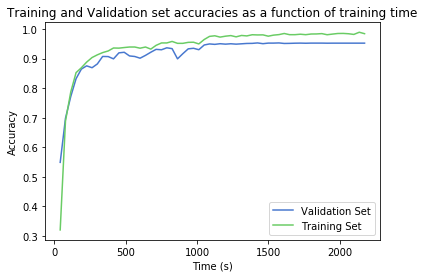

In [29]:
xx = [sum(custom_history.times[0:(i+1)]) for i in range(len(custom_history.times))]
plt.plot(xx, history.history['val_acc'], label = "Validation Set")
plt.plot(xx, history.history['acc'], label = "Training Set")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.title('Training and Validation set accuracies as a function of training time')
#plt.legend('Validation', "Training")
plt.legend(loc=4)

# Evaluation

Once the model is trained, we scale the test set by training set (same way we scaled the validation set above).

In [30]:
(test_x, test_y) = load_hdf5_data(cfg.outdir + "/test.h5", verbose=1)
test_x = do_scale(test_x, cfg.outdir + "/training.scaler", verbose=1)


--- /mnt/speech_commands//compressed_hdf5/test.h5 ---
x.shape: (6835, 24, 64) float32
y.shape: (6835, 21) bool
Loading time: 0.05573868751525879
Scaling time: 0.1093146800994873


In [31]:
# load the model at a specific epoch
# this count starts from zero
filepath = os.path.join(cfg.out_model_dir,
                        "gatedAct_rationBal44_lr0.001_normalization_at_cnnRNN_64newMel_240fr.{epoch:02d}-{val_acc:.4f}.hdf5")

# model snapshow epoch count starts from zero
model_path = glob.glob(os.path.join(cfg.out_model_dir, "*.%02d-0.*.hdf5" % (trained_num_epochs-1)))
model = load_model(model_path[0], custom_objects = {"factor": factor, "internal_reshape": internal_reshape})


In [32]:
model = history.model

In [33]:
# score the model on the test set
y_prob = model.predict(test_x, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(test_y, 1)


## Keras built-in evaluation metrics

This section computes the loss and accuracy on the test set from Keras.

In [34]:
print(model.metrics_names)

['loss', 'acc']


In [35]:
# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("\nAccuracy = {:.4f}".format(accuracy))


6835/6835 [==============================] - 16s 2ms/step

Accuracy = 0.9557


## SKLearn metrics

Keras metrics are important, but we can also add our own metrics which are more informative.

In [36]:
roc = roc_auc_score(test_y, y_prob)
print("ROC AUC:", round(roc, 3))

# the F-score gives a similiar value to the accuracy score, but useful for cross-checking
p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f, 2))

ROC AUC: 0.997
F-Score: 0.96


Confusion matrix provides a great view of the misclassifications - this information can greatly aid us with the Active Learning approach described in the previous notebook.

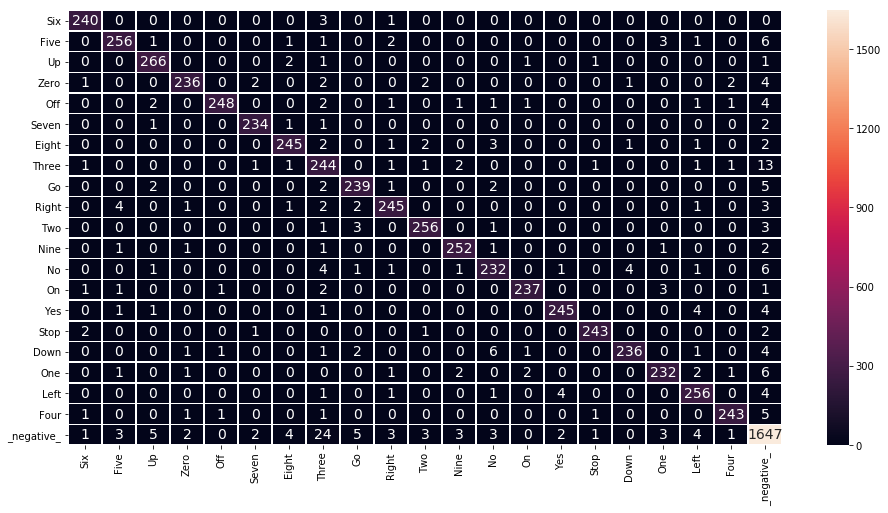

In [37]:
# show the confusion matrix
# labels = cfg.lbs
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, cfg.lbs, cfg.lbs)
plt.figure(figsize = (16,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)
